In [1]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
import jax.random as jr
import pandas as pd

from uncprop.utils.experiment import Experiment
from uncprop.models.elliptic_pde.experiment import PDEReplicate

base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
key = jr.key(7932523)
key, key_experiment = jr.split(key)

experiment_name = 'pde_experiment'
experiment_settings = {
    'name': experiment_name,
    'base_out_dir': base_dir / 'out' / experiment_name,
    'num_reps': 1,
    'base_key': key_experiment,
    'Replicate': PDEReplicate,
    'write_to_file': True,
}

noise_sd = 1e-3
obs_locations = jnp.array([10, 30, 60, 75])
setup_kwargs = {
    'n_design': 12,
    'obs_locations': obs_locations,
    'noise_cov': noise_sd**2 * jnp.identity(len(obs_locations)),
}

def make_subdir_name(setup_kwargs, run_kwargs):
    n = setup_kwargs['n_design']
    return f'n_design_{n}'

run_kwargs = {
    'n_warmup': 50_000
}

pde_experiment = Experiment(subdir_name_fn=make_subdir_name, 
                            **experiment_settings)



Creating new output directory: /Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/out/pde_experiment


In [3]:
results, failed_reps = pde_experiment(setup_kwargs=setup_kwargs, run_kwargs=run_kwargs)

Creating experiment sub-directory: /Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/out/pde_experiment/n_design_12
Running replicate 0
	Fitting surrogate
	Running samplers
No save_results() methods implemented.
0 of 1 replicates failed.


In [4]:
rep = results[0]
posterior = rep.posterior

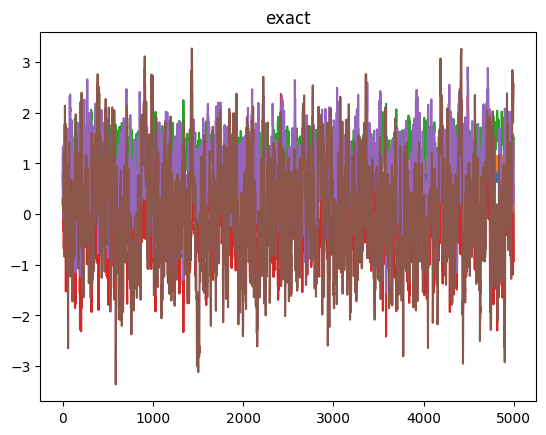

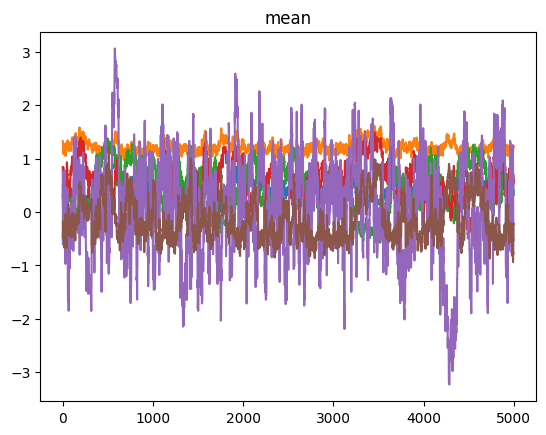

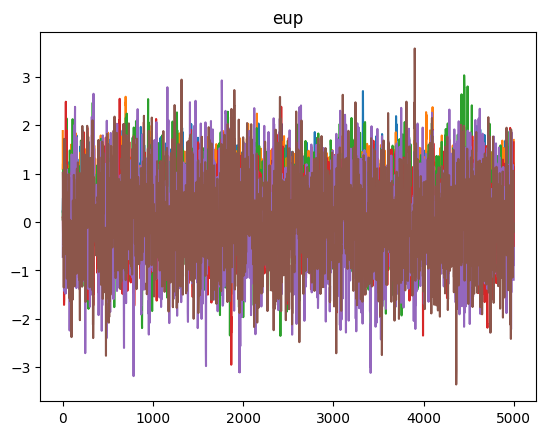

In [5]:
for mcmc_tag in ['exact', 'mean', 'eup']:
    samp = rep.samples[mcmc_tag]
    for i in range(posterior.dim):
        plt.plot(samp[:,i])
        plt.title(mcmc_tag)
    plt.show()

In [6]:
key_prior_samp, key = jr.split(key)

samples = rep.samples
samples['prior'] = posterior.prior.sample(key_prior_samp, n=samples['exact'].shape[0])

In [ ]:
key_subsamp, key = jr.split(key)

dist1_name = 'exact'
dist2_name = 'eup'

dist_names = ['prior', 'eup', 'mean', 'exact']

df_list = []
for name in dist_names:
    df = pd.DataFrame(samples[name], columns=posterior.prior.par_names)
    df['dist'] = name
    df_list.append(df)
samp_df = pd.concat(df_list, ignore_index=True)

# idx = jr.choice(key_subsamp, samp.shape[0], (10_000,))
# post_samp_df = pd.DataFrame(samp[idx], columns=posterior.prior.par_names)

sns.pairplot(samp_df, hue='dist', diag_kind='kde')

In [ ]:
postsamp = samp[-50:,:]
param, log_field, pde_solution, observable = posterior.likelihood.forward_model.forward_with_intermediates(postsamp)
xgrid = posterior.likelihood.forward_model.pde_settings.xgrid

plt.plot(xgrid, pde_solution.T, color='gray')
plt.show()


### Test RFF approximation

In [8]:
def check_rff_approx(key, posterior, surrogate, trajectories, n_test=500):
    inputs = posterior.prior.sample(key, n_test)

    pred = surrogate(inputs)
    pred_rff = trajectories(inputs)
    m = pred.mean
    sd = pred.stdev
    m_rff = jnp.mean(pred_rff, axis=0)
    sd_rff = jnp.std(pred_rff, axis=0)

    for i in range(surrogate.output_dim):
        fig, axs = plt.subplots(1, 2)
        axs = axs.ravel()
        axs[0].scatter(m[i], m_rff[i])
        axs[0].set_title('mean')
        xmin, xmax = axs[0].get_xlim()
        ymin, ymax = axs[0].get_ylim()
        grid = jnp.linspace(xmin, xmax, 100)
        axs[0].plot(grid, grid, color='gray', linewidth=1, linestyle='--', label='y = x')

        axs[1].scatter(sd[i], sd_rff[i])
        axs[1].set_title('sd')
        xmin, xmax = axs[1].get_xlim()
        ymin, ymax = axs[1].get_ylim()
        grid = jnp.linspace(xmin, xmax, 100)
        axs[1].plot(grid, grid, color='gray', linewidth=1, linestyle='--', label='y = x')

        fig.tight_layout()
        fig.show()

In [11]:
from uncprop.models.elliptic_pde.surrogate import (
    _build_batch_basis_funcs,
    _build_batch_basis_noise_dist,
    sample_approx_trajectory,
)

num_rff = 1000
num_trajectories = 10_000

# create batch of trajectories
surrogate = rep.posterior_surrogate.surrogate
batchgp = rep.batchgp

key, key_noise, key_rff, key_plot = jr.split(key, 4)
noise_dist = _build_batch_basis_noise_dist(surrogate, batchgp, num_rff)
noise_realization = noise_dist.sample(key_noise, num_trajectories)
basis_fn = _build_batch_basis_funcs(key_rff, surrogate, batchgp, num_rff)
trajectories = sample_approx_trajectory(basis_fn, noise_realization, surrogate, num_rff)

/var/folders/8y/dh1rsmhx3y13wxw2h2f713qm0000gn/T/ipykernel_65187/1444376584.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


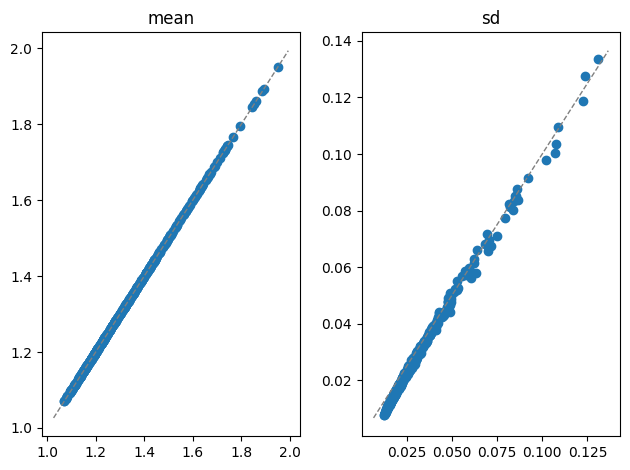

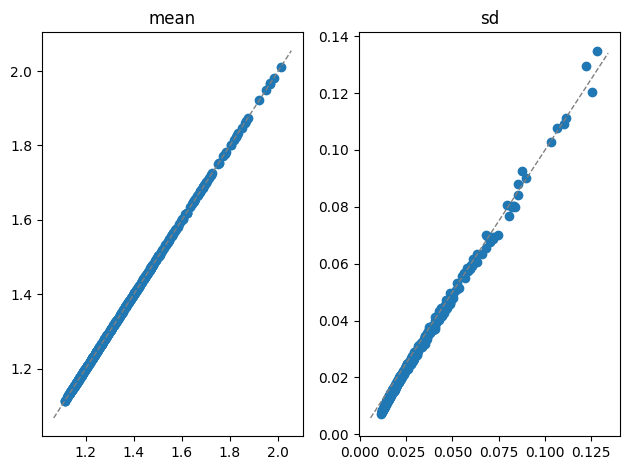

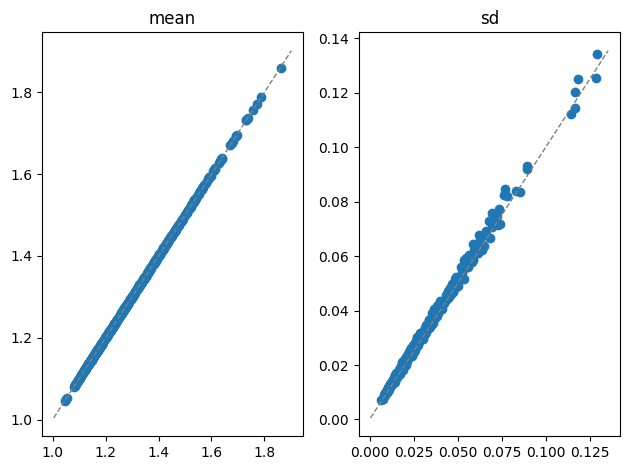

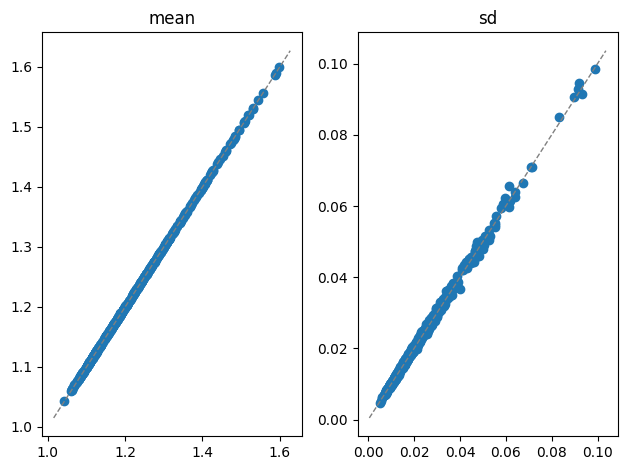

In [12]:
check_rff_approx(key_plot, posterior, surrogate, trajectories, n_test=500)

### Testing vectorization over chains

In [52]:
import jax
from uncprop.core.samplers import init_rwmh_kernel, _init_dist_proposal_cov

def mcmc_loop_multiple_chains(key,
                              kernel,
                              initial_states,
                              num_samples,
                              num_chains):
    """Vectorized MCMC loop over multiple chains"""

    @jax.jit
    def one_step(states, key):
        keys = jr.split(key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states
    
    keys = jr.split(key, num_samples)
    _, states = jax.lax.scan(one_step, initial_states, keys)
    
    return states

In [55]:
from uncprop.utils.distribution import _sample_gaussian_tril
import blackjax

n_chains = 2

key, key_init_pos, key_mcmc = jr.split(key, 3)
key_init_states = jr.split(key, n_chains)
key_steps = jr.split(key, n_chains)

prop_cov = 0.5 * jnp.cov(rep.samples['exact'], rowvar=False)
L = jnp.linalg.cholesky(prop_cov, upper=False)
initial_positions = posterior.prior.sample(key_init_pos, n_chains)

logdensity = lambda x: posterior.log_density(x).squeeze()
def proposal(key, position):
    return _sample_gaussian_tril(key, m=position, L=L).squeeze()

rmh = blackjax.rmh(logdensity, proposal)
initial_states = jax.vmap(rmh.init)(initial_positions, key_init_states)

In [60]:
states = mcmc_loop_multiple_chains(key=key_mcmc, 
                                   kernel=rmh.step,
                                   initial_states=initial_states,
                                   num_samples=10_000,
                                   num_chains=n_chains)

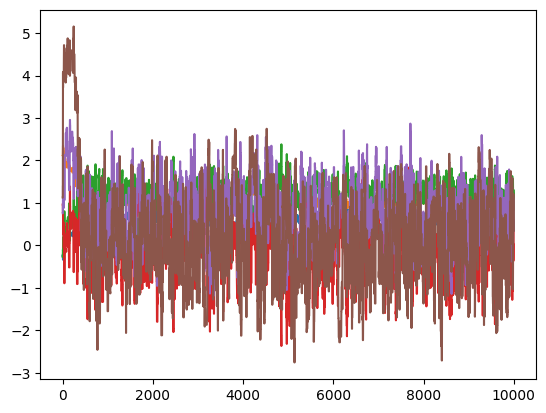

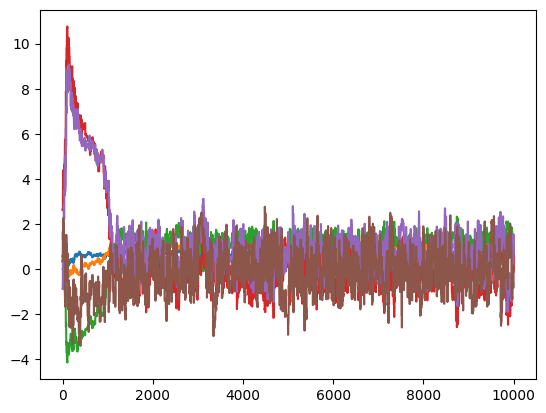

In [61]:
for i in range(n_chains):
    for j in range(posterior.dim):
        plt.plot(states.position[:,i,j])
    plt.show()

In [ ]:


n_chains = 2

prop_cov = 0.5 * jnp.cov(rep.samples['exact'], rowvar=False)
L = jnp.linalg.cholesky(prop_cov, upper=False)
initial_positions = posterior.prior.sample(key_init_pos, n_chains)

def proposal(key, position):
    return _sample_gaussian_tril(key, m=position, L=L).squeeze()

keys = jr.split(key, n_chains)
rmh = blackjax.rmh(posterior.log_density, proposal)
initial_states = jax.vmap(rmh.init)(initial_positions, keys)



In [ ]:
# Symmetric Gaussian proposal


if(prop_cov.ndim == 1):
    prop_cov = jnp.diag(prop_cov)
L = jnp.linalg.cholesky(prop_cov, upper=False)


initial_state = rmh.init(initial_position, key)
kernel = rmh.step

return initial_state, kernel

In [ ]:
states = mcmc_loop_multiple_chains(key=key_mcmc, 
                                   kernel=kernel, 
                                   initial_state=initial_state, 
                                   num_samples=n_samples_total)

(1, 6)

### Test

In [ ]:
key_init, key_run, key_surrogate = jr.split(key, 3)

rep = PDEReplicate(key_init)
rep(key_run, write_to_file=False)
posterior = rep.posterior
forward_model = posterior.likelihood.forward_model

In [ ]:
test = {'a': 1, 'b': 2}
keys = [3, 4]

for key, (k, v) in zip(keys, test.items()):
    print(key, k, v)

In [ ]:
from uncprop.models.elliptic_pde.surrogate import fit_pde_surrogate


design, surrogate, history = fit_pde_surrogate(key=key_surrogate,
                                               posterior=posterior,
                                               n_design=60,
                                               design_method='lhc')

In [ ]:
key_prior, key = jr.split(key)

xtest = posterior.prior.sample(key_prior, 200)
f_true = forward_model(xtest)
pred = surrogate(xtest)

In [ ]:
for i in range(f_true.shape[1]):
    sns.scatterplot(x=f_true[:,i], y=pred.mean[i], color='blue')
    plt.errorbar(f_true[:,i], pred.mean[i], yerr=pred.stdev[i], fmt='none', ecolor='blue', alpha=0.5)
    plt.plot(f_true[:,i], f_true[:,i], 'r--', label="Ground truth")
    plt.xlabel('true')
    plt.ylabel('surrogate')
    plt.legend()
    plt.title(f'KL mode {i+1}')
    plt.show()